In [1]:
#Import Useful Modules
from pyatmos import download_sw_nrlmsise00, read_sw_nrlmsise00 #atmosphere data
from pyatmos import nrlmsise00
import sympy as sym
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import time
plt.style.use('classic')

The EOP file 'finals2000A.all' in C:\Users\Brody/src/iers/ is already the latest.
The Leap Second file 'Leap_Second.dat' in C:\Users\Brody/src/iers/ is already the latest.


In [2]:
# Update space weather data
swfile = download_sw_nrlmsise00() 
swdata = read_sw_nrlmsise00(swfile) 

The Space Weather file 'SW-All.csv' in C:\Users\Brody/src/sw-data/ is already the latest.


In [3]:
M_dict = {
    'He': 4.002602,
    'O': 15.999,
    'N2': 28.014,
    'O2': 31.998,
    'Ar': 39.948,
    'H': 1.00784,
    'N': 14.007,
    'ANM O': 15.999,
}
g_dict = {
    'He': 1.66,
    'O': 1.66,
    'N2': 1.40,
    'O2': 1.40,
    'Ar': 1.66,
    'H': 1.66,
    'N': 1.66,
    'ANM O': 1.66,
}
Av_kg = 6.023e23*1e3 # 1/k mol
R_ideal = 8.314*1e3 #mJ / mol K

In [4]:
#Earth Parameters
r_e = 6.371*1e6 #m
G_e = 3.986*1e14 #m3⋅s−2

In [5]:
t = '2023-11-05 12:00:00' # time(UTC) 
#lat,lon,alt = 25,102,86 # latitude, longitude in [degree], and altitude in [km]

def speed_of_sound(lat, lon, alt, t):
    nrl00 = nrlmsise00(t, (lat, lon, alt), swdata)
    
    t_d = 0
    n_c = 0
    d_c = 0
    for spec in nrl00.nd:
        t_d += nrl00.nd[spec]
        n_c += nrl00.nd[spec]*g_dict[spec]/(g_dict[spec]-1)
        d_c += nrl00.nd[spec]/(g_dict[spec]-1)

    M_net = (nrl00.rho*Av_kg/t_d)
    R_net = R_ideal/M_net
    gamma_net = n_c/d_c
    cs_calc = np.sqrt(gamma_net*R_net*nrl00.T)
    
    return cs_calc, gamma_net, nrl00.rho

In [6]:
#Create symbols to use in equations
#Note: +x is defined as the windward direction
x_s, y_s, z_s = sym.symbols('x y z')
vs = sym.symbols('y z')
R_s, L_s, a_s, M_s = sym.symbols('R L a M')

In [7]:
#----------- SET VEHICLE BODY PARAMETERS ----------
#Radius
R = 2 #m
#Length factor
L = 0.3*R
#Mass
m = 4000 #kg
#Body shape
body_shape = 'ellipsoid'
    
#----------- ADDITIONAL BODY PARAMETERS -------------
#Exclude edges of the surface from the integration domain to prevent errors
bound_sf = (1-1e-15)

In [8]:
##----------- SET FLIGHT VEHICLE SHAPE EQUATIONS #-----------

if body_shape == 'ellipsoid':
    #----------- SET ELLIPSOID EQUATIONS ----------------
    #Windward surface of the ellipsoid
    s = (-(2*z_s*(L_s**2-R_s**2)*sym.cos(a_s)*sym.sin(a_s))-sym.sqrt((2*(L_s**2-R_s**2)*sym.cos(a_s)*sym.sin(a_s)*z_s)**2-4*(R_s**2*sym.cos(a_s)**2+L_s**2*sym.sin(a_s)**2)*(z_s**2*(R_s**2*sym.sin(a_s)**2+L_s**2*sym.cos(a_s)**2)+L_s**2*(y_s**2-R_s**2))))/(2*(R_s**2*sym.cos(a_s)**2+L_s**2*sym.sin(a_s)**2))
    #Upper surface curve when set equal to zero, symmetric across horizontal axis
    bu_f = (2*(L_s**2-R_s**2)*sym.cos(a_s)*sym.sin(a_s)*z_s)**2-4*(R_s**2*sym.cos(a_s)**2+L_s**2*sym.sin(a_s)**2)*(z_s**2*(R_s**2*sym.sin(a_s)**2+L_s**2*sym.cos(a_s)**2)+L_s**2*(y_s**2-R_s**2))

elif body_shape == 'cone':
    #----------- SET CONE EQUATIONS ----------------
    #Windward surface of the ellipsoid
    s = ((2*R_s**2*(z_s-L_s*sym.sin(a_s))*sym.cos(a_s)*sym.sin(a_s)+2*(z_s-L_s*sym.sin(a_s))*sym.cos(a_s)*sym.sin(a_s))+sym.sqrt((-2*R_s**2*(z_s-L_s*sym.sin(a_s))*sym.cos(a_s)*sym.sin(a_s)-2*(z_s-L_s*sym.sin(a_s))*sym.cos(a_s)*sym.sin(a_s))**2-4*(R_s**2*sym.cos(a_s)**2-sym.sin(a_s)**2)*(R_s**2*(z_s-L_s*sym.sin(a_s))**2*sym.sin(a_s)**2-(z_s-L_s*sym.sin(a_s))**2*sym.cos(a_s)**2-y_s**2)))/(2*(R_s**2*sym.cos(a_s)**2-sym.sin(a_s)**2))
    #Upper surface curve when set equal to zero, symmetric across horizontal axis
    bu_f = sym.cos(a_s)*sym.sqrt(L_s**2*R_s**2-y_s**2)-z_s

#--------- USEFUL CALCULATION QUANTITIES -----------
#Partial derivatives of the surface function
py = sym.diff(s, y_s)
pz = sym.diff(s, z_s)

#Solution for the upper boundary of integration
bu = sym.solve(bu_f, z_s)
bu = bu[len(bu)-1]

#Square of the normal component of the surface, n_x^2
nx2 = 1/(1+py**2+pz**2)

#Integrand for calculating coeficient of lift
nx2pz = nx2*pz

In [9]:
#z_stag = sym.solve(pz.subs(y_s,0), z_s)
#z_stag = z_stag[len(z_stag)-1]

In [10]:
#z_stag[len(z_stag)-1].subs(L_s, L).subs(R_s, R).subs(a_s, 1).evalf()

In [11]:
#----- FUNCTION FOR GETTING C_d and C_l FROM AOA -------
def coeff_aoa(aoa, area_scaled = True):
    #Convert from degrees to radians
    aoa = aoa*np.pi/180
    
    #------- CREATE FAST FUNCTIONS FOR INTEGRATION ---------
    #Upper edge height from  pitching axis as function of dist along that axis
    #For a given body geometry and angle of attack
    fvbu = bound_sf*bu.subs(L_s,L).subs(R_s,R).subs(a_s,aoa).evalf()
    syms = [sym.parse_expr(item) for item in [str(fvbu)]]
    f_bu = [sym.lambdify(y_s, f) for f in syms]

    #C_d integrand as a function of position
    #For a given body geometry and angle of attack
    fvnx2 = nx2.subs(L_s,L).subs(R_s,R).subs(a_s,aoa).evalf()
    syms = [sym.parse_expr(item) for item in [str(fvnx2)]]
    f_nx2 = [sym.lambdify(vs, f) for f in syms]

    #C_l integrand as a function of position
    #For a given body geometry and angle of attack
    fnx2pz = nx2pz.subs(L_s,L).subs(R_s,R).subs(a_s,aoa).evalf()
    syms = [sym.parse_expr(item) for item in [str(fnx2pz)]]
    f_nx2pz = [sym.lambdify(vs, f) for f in syms]
    
    #------- INTEGRATIONS ---------
    #Projected cross sectional area (half)
    A = integrate.dblquad(lambda z, y: 1, 0, R, lambda y: -[f(y) for f in f_bu][0], lambda y: [f(y) for f in f_bu][0])[0]
    
    #C_d (divided by maximum C_p)
    C_d_Cpm_i = integrate.dblquad(lambda z, y: [f(y, z) for f in f_nx2][0] , 0, R, lambda y: -[f(y) for f in f_bu][0], lambda y: [f(y) for f in f_bu][0])[0]

    #C_l (divided by maximum C_p)
    C_l_Cpm_i = integrate.dblquad(lambda z, y: [f(y, z) for f in f_nx2pz][0] , 0, R, lambda y: -[f(y) for f in f_bu][0], lambda y: [f(y) for f in f_bu][0])[0]
    
    if not area_scaled:
        #Return purely the aero coefficients
        C_d_Cpm_i = C_d_Cpm_i/A
        C_l_Cpm_i = C_l_Cpm_i/A

        #Otherwise return aero coefficients * A/2 for easier computation
        
    return C_d_Cpm_i, C_l_Cpm_i

In [12]:
#----- FUNCTION FOR GETTING INSTANTANEOUS AERO PARAMETERS -------
def instant_coeff(C_d_Cpm, C_l_Cpm, M, gamma):
    #Instantaneous coeffcient of max pressure
    C_p_max = (2/(gamma*M**2))*((((gamma+1)**2*M**2)/(4*gamma*M**2-2*gamma+2))**(gamma/(gamma-1))*((1-gamma+2*gamma*M**2)/(gamma+1))-1)

    #Instantaneous coeffcient of drag
    C_d = C_d_Cpm*C_p_max

    #Instantaneous coeffcient of lift
    C_l = C_l_Cpm*C_p_max
    
    return C_p_max, C_d, C_l

In [13]:
def basic_step(r_vec, v_vec, dt=1.0, bank = 0.0):
    #------- FLIGHT INSTANTANEOUS CONDITION --------
    v_mag = np.linalg.norm(v_vec)
    z_alt = np.linalg.norm(r_vec)-r_e
    d_vec = r_vec/np.linalg.norm(r_vec)
    d_vel = (v_vec/v_mag)
    bank = bank*(np.pi/180)

    #Global Position Coordinates
    lat_int = 90-np.arccos(d_vec[2])*180/np.pi
    long_int = np.arccos(d_vec[0]/np.sin((90-lat_int)*np.pi/180))*180/np.pi

    cs_calc, gamma_calc, rho_calc = speed_of_sound(lat_int, long_int, z_alt/1e3, t)

    M_v = v_mag/cs_calc
    gamma_v = gamma_calc
    
    if M_v < 5 or z_alt<0:
        return r_vec, v_vec, False

    #Instantaneous aerodynamic coefficients
    C_p_max, C_d, C_l = instant_coeff(C_d_Cpm, C_l_Cpm , M=M_v, gamma=gamma_v)

    D_f = C_d*rho_calc*v_mag*v_mag
    D_acc = D_f/m

    L_f = C_l*rho_calc*v_mag*v_mag
    L_acc = L_f/m

    W_acc = G_e/(z_alt+r_e)**2

    r_vec += dt * v_vec
    v_vec += -dt * W_acc * d_vec
    v_vec += -dt * D_acc * d_vel
    
    #Lift Caclulations
        #Zero bank lift direction
    d_l0b = np.cross(d_vel, np.cross(d_vel, d_vec))
    d_lift = np.cos(bank)*d_l0b + np.sin(bank) * np.cross(d_vel, d_l0b)
    v_vec += dt * L_acc * d_lift
    
    acc_g = np.sqrt(D_acc**2 + (L_acc)**2)
        
    path_alt.append(z_alt*1e-3)
    path_vel.append(v_mag*1e-3)
    path_mach.append(M_v)
    path_long.append(long_int)
    path_acc.append(acc_g)
    
    return r_vec, v_vec, True

In [14]:
#------- INITIALIZE FLIGHT CONDITIONS --------
lat_i = 0
long_i = 0
z_i = 400000*0.3048
entry_rot = -2*np.pi/180
v_entry_mag = 8000

dt_mult = 1.

In [15]:
#------- INITIALIZE FLIGHT CONDITIONS --------
lat_i = 0
long_i = 0
z_i = 121920
entry_rot = -10*np.pi/180
v_entry_mag = np.sqrt(G_e/r_e)

dt_mult = 2.
print(v_entry_mag)

7909.788019132537


In [16]:
#Calculate ceofficients for an angle of attack
C_d_Cpm, C_l_Cpm = coeff_aoa(0.01, area_scaled = True)

z_vec = np.array([z_i*np.sin((90-lat_i)*np.pi/180)*np.cos(long_i*np.pi/180), z_i*np.sin((90-lat_i)*np.pi/180)*np.sin(long_i*np.pi/180), z_i*np.cos((90-lat_i)*np.pi/180)])
r_vec = (np.linalg.norm(z_vec)+r_e)*z_vec/np.linalg.norm(z_vec)
v_vec = np.array([v_entry_mag*np.sin(entry_rot), v_entry_mag*np.cos(entry_rot), 0.0])

path_alt = []
path_vel = []
path_mach = []
path_long = []
path_acc = []

for i in range(int(1000*dt_mult)):
    r_vec, v_vec, hyper = basic_step(r_vec, v_vec, dt=1./dt_mult, bank=90)
    if not hyper:
        break
    
path_alt_0 = path_alt
path_vel_0 = path_vel
path_mach_0 = path_mach
path_long_0 = path_long
path_acc_0 = path_acc

C:\Users\Brody\anaconda3\envs\ae483\lib\site-packages\pyatmos\msise\spaceweather.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ap_c = aph_tmp_b0[i]


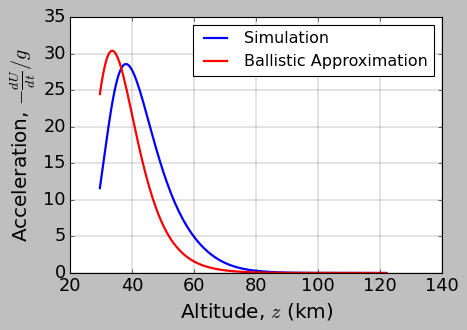

In [17]:
z_list = np.linspace(path_alt_0[0], path_alt_0[-1], len(path_alt_0))*1000
Gamma = m/(np.pi*R**2*1)
Zeta = (Gamma/(1.225*6700))*np.sin(-entry_rot)
ballistic_g = (v_entry_mag**2/9.81)*(1.225/(2*Gamma))*np.exp(-z_list/6700)*np.exp(-np.exp(-z_list/6700)/Zeta)


plt.figure(figsize=(6,4))

plt.plot(path_alt_0, np.array(path_acc_0)/9.81, label='Simulation', c='b', linewidth=2)
plt.plot(z_list/1000, ballistic_g, label='Ballistic Approximation', c='r', linewidth=2)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#plt.title('Equilibrium Composition of Air at High Temperatures', fontsize = 22)
plt.ylabel(r'Acceleration, $-\frac{dU}{dt}/g$', fontsize = 18)
plt.xlabel(r'Altitude, $z$ (km)', fontsize = 18)
plt.grid(linestyle='-',linewidth=0.2)
plt.legend()#loc='lower right', bbox_to_anchor=(0.65, 0.15, 0.5, 0.5), prop={'size': 14})
plt.show()

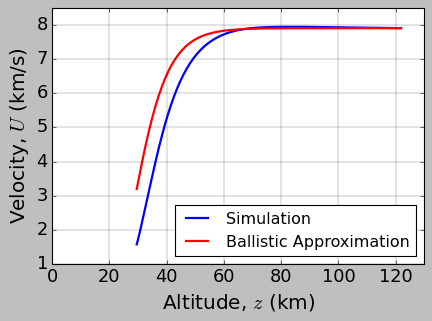

In [18]:
plt.figure(figsize=(6,4))

ballistic_U = v_entry_mag*np.exp(-np.exp(-z_list/6700)/(2*Zeta))

plt.plot(path_alt_0, np.array(path_vel_0), label='Simulation', c='b', linewidth=2)
plt.plot(z_list/1000, ballistic_U/1000, label='Ballistic Approximation', c='r', linewidth=2)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(1,8.5)
plt.xlim(0,130)
plt.ylabel(r'Velocity, $U$ (km/s)', fontsize = 18)
plt.xlabel(r'Altitude, $z$ (km)', fontsize = 18)
plt.grid(linestyle='-',linewidth=0.2)
plt.legend(loc='lower right')
plt.show()

In [19]:
custom_rho = []
for index in range(len(z_list)):
    nrl00 = nrlmsise00(t, (0, 0, z_list[index]/1000), swdata)
    custom_rho.append(nrl00.rho)

custom_rho = np.array(custom_rho)

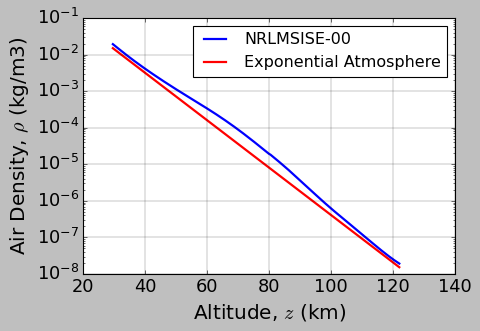

In [20]:
exp_rho=1.225*np.exp(-z_list/6700)

plt.figure(figsize=(6,4))

plt.plot(z_list/1000, custom_rho, label='NRLMSISE-00', c='b', linewidth=2)
plt.plot(z_list/1000, exp_rho, label='Exponential Atmosphere', c='r', linewidth=2)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.yscale('log')
#plt.title('Equilibrium Composition of Air at High Temperatures', fontsize = 22)
plt.ylabel(r'Air Density, $\rho$ (kg/m3)', fontsize = 18)
plt.xlabel(r'Altitude, $z$ (km)', fontsize = 18)
plt.grid(linestyle='-',linewidth=0.2)
plt.legend()#loc='lower right', bbox_to_anchor=(0.65, 0.15, 0.5, 0.5), prop={'size': 14})
plt.show()

In [21]:
#----------- SET VEHICLE BODY PARAMETERS ----------
#Radius
R = 2 #m
#Length factor
L = 0.1*R
#Mass
m = 4000 #kg
#Body shape
body_shape = 'ellipsoid'
    
##----------- SET FLIGHT VEHICLE SHAPE EQUATIONS #-----------
if body_shape == 'ellipsoid':
    #----------- SET ELLIPSOID EQUATIONS ----------------
    #Windward surface of the ellipsoid
    s = (-(2*z_s*(L_s**2-R_s**2)*sym.cos(a_s)*sym.sin(a_s))-sym.sqrt((2*(L_s**2-R_s**2)*sym.cos(a_s)*sym.sin(a_s)*z_s)**2-4*(R_s**2*sym.cos(a_s)**2+L_s**2*sym.sin(a_s)**2)*(z_s**2*(R_s**2*sym.sin(a_s)**2+L_s**2*sym.cos(a_s)**2)+L_s**2*(y_s**2-R_s**2))))/(2*(R_s**2*sym.cos(a_s)**2+L_s**2*sym.sin(a_s)**2))
    #Upper surface curve when set equal to zero, symmetric across horizontal axis
    bu_f = (2*(L_s**2-R_s**2)*sym.cos(a_s)*sym.sin(a_s)*z_s)**2-4*(R_s**2*sym.cos(a_s)**2+L_s**2*sym.sin(a_s)**2)*(z_s**2*(R_s**2*sym.sin(a_s)**2+L_s**2*sym.cos(a_s)**2)+L_s**2*(y_s**2-R_s**2))

#--------- USEFUL CALCULATION QUANTITIES -----------
#Partial derivatives of the surface function
py = sym.diff(s, y_s)
pz = sym.diff(s, z_s)

#Solution for the upper boundary of integration
bu = sym.solve(bu_f, z_s)
bu = bu[len(bu)-1]

#Square of the normal component of the surface, n_x^2
nx2 = 1/(1+py**2+pz**2)

#Integrand for calculating coeficient of lift
nx2pz = nx2*pz

aoa_range = np.linspace(0,30,31)
cd_range_01 = []
cl_range_01 = []
for aoa in aoa_range:
    if aoa==0:
        aoa=0.001
    C_d_Cpm, C_l_Cpm = coeff_aoa(aoa, area_scaled = False)
    cd_range_01.append(C_d_Cpm)
    cl_range_01.append(C_l_Cpm)

In [22]:
#----------- SET VEHICLE BODY PARAMETERS ----------
#Radius
R = 2 #m
#Length factor
L = 0.2*R
#Mass
m = 4000 #kg
#Body shape
body_shape = 'ellipsoid'
    
##----------- SET FLIGHT VEHICLE SHAPE EQUATIONS #-----------
if body_shape == 'ellipsoid':
    #----------- SET ELLIPSOID EQUATIONS ----------------
    #Windward surface of the ellipsoid
    s = (-(2*z_s*(L_s**2-R_s**2)*sym.cos(a_s)*sym.sin(a_s))-sym.sqrt((2*(L_s**2-R_s**2)*sym.cos(a_s)*sym.sin(a_s)*z_s)**2-4*(R_s**2*sym.cos(a_s)**2+L_s**2*sym.sin(a_s)**2)*(z_s**2*(R_s**2*sym.sin(a_s)**2+L_s**2*sym.cos(a_s)**2)+L_s**2*(y_s**2-R_s**2))))/(2*(R_s**2*sym.cos(a_s)**2+L_s**2*sym.sin(a_s)**2))
    #Upper surface curve when set equal to zero, symmetric across horizontal axis
    bu_f = (2*(L_s**2-R_s**2)*sym.cos(a_s)*sym.sin(a_s)*z_s)**2-4*(R_s**2*sym.cos(a_s)**2+L_s**2*sym.sin(a_s)**2)*(z_s**2*(R_s**2*sym.sin(a_s)**2+L_s**2*sym.cos(a_s)**2)+L_s**2*(y_s**2-R_s**2))

#--------- USEFUL CALCULATION QUANTITIES -----------
#Partial derivatives of the surface function
py = sym.diff(s, y_s)
pz = sym.diff(s, z_s)

#Solution for the upper boundary of integration
bu = sym.solve(bu_f, z_s)
bu = bu[len(bu)-1]

#Square of the normal component of the surface, n_x^2
nx2 = 1/(1+py**2+pz**2)

#Integrand for calculating coeficient of lift
nx2pz = nx2*pz

aoa_range = np.linspace(0,30,31)
cd_range_02 = []
cl_range_02 = []
for aoa in aoa_range:
    if aoa==0:
        aoa=0.001
    C_d_Cpm, C_l_Cpm = coeff_aoa(aoa, area_scaled = False)
    cd_range_02.append(C_d_Cpm)
    cl_range_02.append(C_l_Cpm)

In [23]:
#----------- SET VEHICLE BODY PARAMETERS ----------
#Radius
R = 2 #m
#Length factor
L = 0.3*R
#Mass
m = 4000 #kg
#Body shape
body_shape = 'ellipsoid'
    
##----------- SET FLIGHT VEHICLE SHAPE EQUATIONS #-----------
if body_shape == 'ellipsoid':
    #----------- SET ELLIPSOID EQUATIONS ----------------
    #Windward surface of the ellipsoid
    s = (-(2*z_s*(L_s**2-R_s**2)*sym.cos(a_s)*sym.sin(a_s))-sym.sqrt((2*(L_s**2-R_s**2)*sym.cos(a_s)*sym.sin(a_s)*z_s)**2-4*(R_s**2*sym.cos(a_s)**2+L_s**2*sym.sin(a_s)**2)*(z_s**2*(R_s**2*sym.sin(a_s)**2+L_s**2*sym.cos(a_s)**2)+L_s**2*(y_s**2-R_s**2))))/(2*(R_s**2*sym.cos(a_s)**2+L_s**2*sym.sin(a_s)**2))
    #Upper surface curve when set equal to zero, symmetric across horizontal axis
    bu_f = (2*(L_s**2-R_s**2)*sym.cos(a_s)*sym.sin(a_s)*z_s)**2-4*(R_s**2*sym.cos(a_s)**2+L_s**2*sym.sin(a_s)**2)*(z_s**2*(R_s**2*sym.sin(a_s)**2+L_s**2*sym.cos(a_s)**2)+L_s**2*(y_s**2-R_s**2))

#--------- USEFUL CALCULATION QUANTITIES -----------
#Partial derivatives of the surface function
py = sym.diff(s, y_s)
pz = sym.diff(s, z_s)

#Solution for the upper boundary of integration
bu = sym.solve(bu_f, z_s)
bu = bu[len(bu)-1]

#Square of the normal component of the surface, n_x^2
nx2 = 1/(1+py**2+pz**2)

#Integrand for calculating coeficient of lift
nx2pz = nx2*pz

aoa_range = np.linspace(0,30,31)
cd_range_03 = []
cl_range_03 = []
for aoa in aoa_range:
    if aoa==0:
        aoa=0.001
    C_d_Cpm, C_l_Cpm = coeff_aoa(aoa, area_scaled = False)
    cd_range_03.append(C_d_Cpm)
    cl_range_03.append(C_l_Cpm)

In [24]:
#----------- SET VEHICLE BODY PARAMETERS ----------
#Radius
R = 2 #m
#Length factor
L = 0.4*R
#Mass
m = 4000 #kg
#Body shape
body_shape = 'ellipsoid'
    
##----------- SET FLIGHT VEHICLE SHAPE EQUATIONS #-----------
if body_shape == 'ellipsoid':
    #----------- SET ELLIPSOID EQUATIONS ----------------
    #Windward surface of the ellipsoid
    s = (-(2*z_s*(L_s**2-R_s**2)*sym.cos(a_s)*sym.sin(a_s))-sym.sqrt((2*(L_s**2-R_s**2)*sym.cos(a_s)*sym.sin(a_s)*z_s)**2-4*(R_s**2*sym.cos(a_s)**2+L_s**2*sym.sin(a_s)**2)*(z_s**2*(R_s**2*sym.sin(a_s)**2+L_s**2*sym.cos(a_s)**2)+L_s**2*(y_s**2-R_s**2))))/(2*(R_s**2*sym.cos(a_s)**2+L_s**2*sym.sin(a_s)**2))
    #Upper surface curve when set equal to zero, symmetric across horizontal axis
    bu_f = (2*(L_s**2-R_s**2)*sym.cos(a_s)*sym.sin(a_s)*z_s)**2-4*(R_s**2*sym.cos(a_s)**2+L_s**2*sym.sin(a_s)**2)*(z_s**2*(R_s**2*sym.sin(a_s)**2+L_s**2*sym.cos(a_s)**2)+L_s**2*(y_s**2-R_s**2))

#--------- USEFUL CALCULATION QUANTITIES -----------
#Partial derivatives of the surface function
py = sym.diff(s, y_s)
pz = sym.diff(s, z_s)

#Solution for the upper boundary of integration
bu = sym.solve(bu_f, z_s)
bu = bu[len(bu)-1]

#Square of the normal component of the surface, n_x^2
nx2 = 1/(1+py**2+pz**2)

#Integrand for calculating coeficient of lift
nx2pz = nx2*pz

aoa_range = np.linspace(0,30,31)
cd_range_04 = []
cl_range_04 = []
for aoa in aoa_range:
    if aoa==0:
        aoa=0.001
    C_d_Cpm, C_l_Cpm = coeff_aoa(aoa, area_scaled = False)
    cd_range_04.append(C_d_Cpm)
    cl_range_04.append(C_l_Cpm)

In [25]:
gamma = 1.4
M = 25
Cpm = (2/(gamma*M**2))*((((gamma+1)**2*M**2)/(4*gamma*M**2-2*gamma+2))**(gamma/(gamma-1))*((1-gamma+2*gamma*M**2)/(gamma+1))-1)

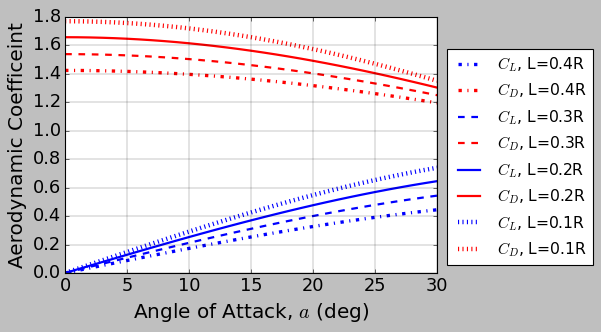

In [26]:
plt.figure(figsize=(6,4))

plt.plot(aoa_range, Cpm*np.array(cl_range_04), linestyle='dashdot', c='b', linewidth=3, label=r'$C_L$, L=0.4R')
plt.plot(aoa_range, Cpm*np.array(cd_range_04), linestyle='dashdot', c='r', linewidth=3, label=r'$C_D$, L=0.4R')
plt.plot(aoa_range, Cpm*np.array(cl_range_03), linestyle='dashed', c='b', linewidth=2, label=r'$C_L$, L=0.3R')
plt.plot(aoa_range, Cpm*np.array(cd_range_03), linestyle='dashed', c='r', linewidth=2, label=r'$C_D$, L=0.3R')
plt.plot(aoa_range, Cpm*np.array(cl_range_02), c='b', linewidth=2, label=r'$C_L$, L=0.2R')
plt.plot(aoa_range, Cpm*np.array(cd_range_02), c='r', linewidth=2, label=r'$C_D$, L=0.2R')
plt.plot(aoa_range, Cpm*np.array(cl_range_01), linestyle='dotted', c='b', linewidth=4, label=r'$C_L$, L=0.1R')
plt.plot(aoa_range, Cpm*np.array(cd_range_01), linestyle='dotted', c='r', linewidth=4, label=r'$C_D$, L=0.1R')

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#plt.title('Equilibrium Composition of Air at High Temperatures', fontsize = 22)
plt.ylabel(r'Aerodynamic Coefficeint', fontsize = 18)
plt.xlabel(r'Angle of Attack, $a$ (deg)', fontsize = 18)
plt.grid(linestyle='-',linewidth=0.2)
plt.legend(loc='lower right', bbox_to_anchor=(0.94, 0.0, 0.5, 0.5), prop={'size': 14})
plt.show()

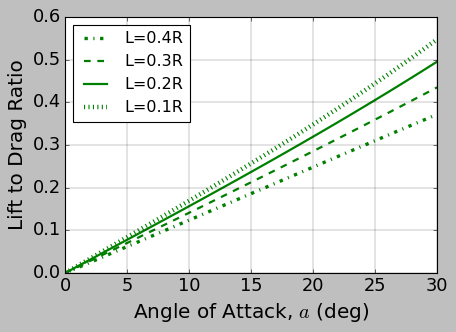

In [27]:
plt.figure(figsize=(6,4))

plt.plot(aoa_range, np.array(cl_range_04)/np.array(cd_range_04), linestyle='dashdot', c='g', linewidth=3, label=r'L=0.4R')
plt.plot(aoa_range, np.array(cl_range_03)/np.array(cd_range_03), linestyle='dashed', c='g', linewidth=2, label=r'L=0.3R')
plt.plot(aoa_range, np.array(cl_range_02)/np.array(cd_range_02), c='g', linewidth=2, label=r'L=0.2R')
plt.plot(aoa_range, np.array(cl_range_01)/np.array(cd_range_01), linestyle='dotted', c='g', linewidth=4, label=r'L=0.1R')

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#plt.title('Equilibrium Composition of Air at High Temperatures', fontsize = 22)
plt.ylabel(r'Lift to Drag Ratio', fontsize = 18)
plt.xlabel(r'Angle of Attack, $a$ (deg)', fontsize = 18)
plt.grid(linestyle='-',linewidth=0.2)
plt.legend(loc='upper left') #, bbox_to_anchor=(0.94, 0.0, 0.5, 0.5), prop={'size': 14})
plt.show()